## Trabalho Final Sistemas Inteligentes 2

-  Alunos:
-  Gustavo Rodrigues Bassaco               RA: 2207206
-  Thomas Oliveira Rocha Sampaio Silva     RA: 2207281
-  Gabriel Molina de Lima                  RA: 2208423


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf
import librosa.display
import seaborn as sns
import numpy as np
import librosa
import random
import keras
import os



c:\Users\gusta\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Criando arquivos com media dos features do audio para classificação




In [3]:

# Caminho para o áudio original
audio_path = './data/genres_original/'
features_path = './data/features_mean/'

generes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for i in range(len(generes)):
    genre = generes[i]
    audio = audio_path + genre + '/'
    
    # Criar diretório se não existir
    if not os.path.exists(features_path + genre):
        os.makedirs(features_path + genre)
    
    # Listar todos os arquivos no diretório
    all_files = os.listdir(audio)

    # Filtrar os arquivos que correspondem ao padrão de nome de arquivo
    audio_files = [f for f in all_files]
    
    for audio_file in audio_files:
        # Carregar o arquivo de áudio
        if audio_file == 'jazz.00054.wav': #arquivo corrompido
            continue
        
        sound, sr = librosa.load(audio + audio_file, sr=None)
        intervalo = int(22050 * 3)

        # Criar nove conjuntos de coeficientes MFCC e outras medidas
        for j in range(1, 10):
            start = int((j - 1) * intervalo)
            end = int(j * intervalo)
            
            sound_interval = sound[start:end]
            # Extrair características
            mfccs = np.mean(librosa.feature.mfcc(y=sound_interval, sr=sr, n_mfcc=128), axis=1, keepdims=True)
            chroma_stft = np.mean(librosa.feature.chroma_stft(y=sound_interval, sr=sr), axis=1, keepdims=True)
            rms = np.mean(librosa.feature.rms(y=sound_interval))
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=sound_interval, sr=sr))
            spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=sound_interval, sr=sr))
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=sound_interval, sr=sr))
            zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=sound_interval))

            feature_file = audio_file.replace('.wav', f'_{j}.npy')
            np.save(features_path + genre + '/' + feature_file, np.vstack((mfccs, chroma_stft, rms, spectral_centroid,
                                                                                spectral_bandwidth, rolloff, zero_crossing_rate)))

## Carregando arquivos

In [2]:
# Lista para armazenar os espectrogramas
audio_path = './data/genres_original/'
features_mean_path = './data/features_mean/'
generes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

features_mean = []
labels_mean = []

for genre in generes:
    genre_path = features_mean_path + genre + '/'
    # Listar todos os arquivos no diretório
    all_files = os.listdir(genre_path)
    for file in all_files:

        fs = np.load(genre_path + file)
        features_mean.append(fs)
        labels_mean.append(genre)


# Converter a lista de emfccas para um array numpy
features_mean = np.array(features_mean)
labels_mean = np.array(labels_mean)

# Codificar as labels (gêneros musicais) em números
label_encoder = LabelEncoder()
labels_mean = label_encoder.fit_transform(labels_mean)

# normalizar
max_c = np.max(np.abs(features_mean))
features_mean = features_mean / max_c

# Dividir os dados em treino e teste
X_train_mean, X_test_mean, Y_train_mean, Y_test_mean = train_test_split(features_mean, labels_mean, test_size=0.2, random_state=42, stratify=labels_mean)

Y_train_mean = keras.utils.to_categorical(Y_train_mean, num_classes=10)
Y_test_mean = keras.utils.to_categorical(Y_test_mean, num_classes=10)
print(X_test_mean.shape)

(1799, 145, 1)


## Carregar modelo

In [3]:
i = 0
classificador = tf.keras.models.load_model("modelo_classificador" + str(i)+".h5")

classificador.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=["accuracy","MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"])



## Definindo modelo classificador

In [ ]:

classificador = keras.models.Sequential([
    keras.layers.Dense(145, activation='relu', input_shape=[145]),
    keras.layers.Dense(104, activation='relu'),
    keras.layers.Dense(64, activation='relu'),     
    keras.layers.Dense(32, activation='relu'),      
    keras.layers.Dense(10, activation='softmax') 
])

classificador.summary()

classificador.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=["accuracy","MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 145)               21170     
                                                                 
 dense_1 (Dense)             (None, 104)               15184     
                                                                 
 dense_2 (Dense)             (None, 64)                6720      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 45,484
Trainable params: 45,484
Non-trainable params: 0
_________________________________________________________________


treinando modelo classificador

In [ ]:

history = classificador.fit(
    X_train_mean, Y_train_mean,
    epochs=720,
    batch_size=8,
    shuffle=True,
    validation_data=(X_test_mean, Y_test_mean)
)

Epoch 1/720
899/899 [==============================] - 2s 2ms/step - loss: 2.0302 - accuracy: 0.2328 - mean_squared_error: 0.0839 - root_mean_squared_error: 0.2897 - mean_absolute_error: 0.1684 - val_loss: 1.8916 - val_accuracy: 0.2852 - val_mean_squared_error: 0.0806 - val_root_mean_squared_error: 0.2839 - val_mean_absolute_error: 0.1611
Epoch 2/720
899/899 [==============================] - 1s 2ms/step - loss: 1.8853 - accuracy: 0.2818 - mean_squared_error: 0.0801 - root_mean_squared_error: 0.2830 - mean_absolute_error: 0.1605 - val_loss: 1.8322 - val_accuracy: 0.2996 - val_mean_squared_error: 0.0785 - val_root_mean_squared_error: 0.2802 - val_mean_absolute_error: 0.1596
Epoch 3/720
899/899 [==============================] - 1s 2ms/step - loss: 1.7862 - accuracy: 0.3172 - mean_squared_error: 0.0766 - root_mean_squared_error: 0.2768 - mean_absolute_error: 0.1546 - val_loss: 1.6927 - val_accuracy: 0.3535 - val_mean_squared_error: 0.0737 - val_root_mean_squared_error: 0.2715 - val_mean_

salvando modelo

In [ ]:
# i = 0
# classificador.save("modelo_classificador" + str(i)+".h5")

acuracia treino

Precisão no Treino: 98.85%


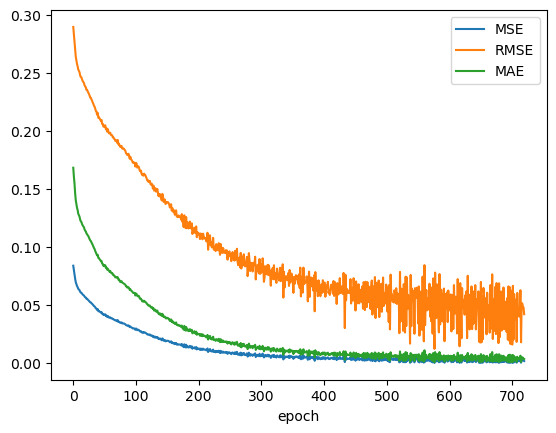

In [ ]:
# Obter a precisão no treino
train_accuracy = history.history['accuracy'][-1]

# Exibir a precisão no treino
print(f'Precisão no Treino: {train_accuracy * 100:.2f}%')

# Plotar métricas de treinamento
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('epoch')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')
plt.show()

## Matriz de confusão

57/57 [==============================] - 0s 896us/step
(7192, 145, 1)


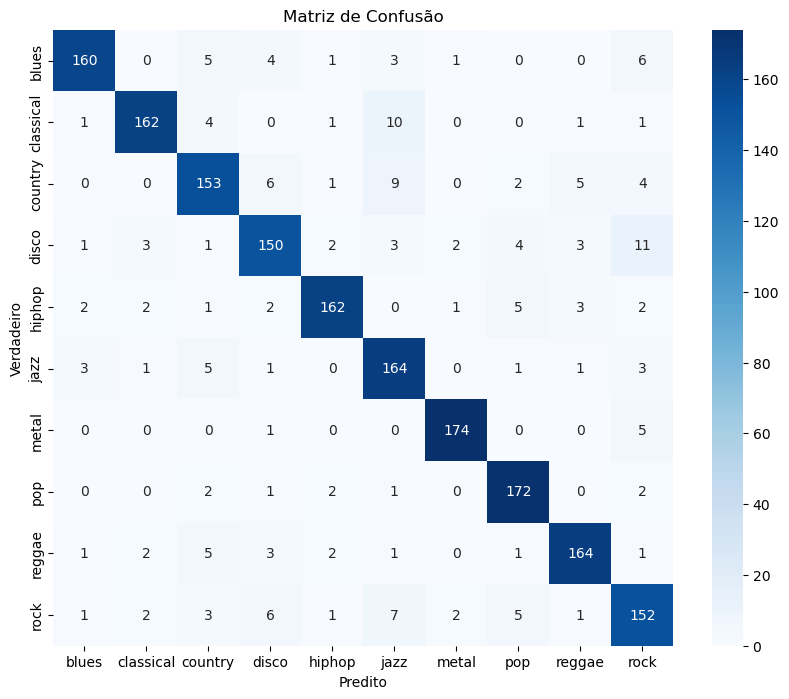

In [4]:
# Avaliar o modelo
y_pred = classificador.predict(X_test_mean)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test_mean, axis=1)

print(X_train_mean.shape)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

## Acuracia obtida

In [5]:
# Calcular a porcentagem total de acertos
acuracia_total = accuracy_score(y_true, y_pred_classes)

# Exibir a porcentagem total de acertos
print(f'Acurácia Total: {acuracia_total * 100:.2f}%\n')

# Calcular a precisão para cada classe
precision_per_class = precision_score(y_true, y_pred_classes, average=None)


# Exibir a precisão para cada classe
for i, precision in enumerate(precision_per_class):
    genre = label_encoder.classes_[i]
    print(f'Precisão para {genre}: {precision * 100:.2f}%')



Acurácia Total: 89.66%

Precisão para blues: 94.67%
Precisão para classical: 94.19%
Precisão para country: 85.47%
Precisão para disco: 86.21%
Precisão para hiphop: 94.19%
Precisão para jazz: 82.83%
Precisão para metal: 96.67%
Precisão para pop: 90.53%
Precisão para reggae: 92.13%
Precisão para rock: 81.28%


## testando classificador
- escolhendo uma musica aleatória

In [6]:
audio_path = './data/genres_original/'

valores =   [0, 100,  # 0 - blues
            100, 200, # 1 - classical
            200, 300, # 2 - country
            300, 400, # 3 - disco
            400, 500, # 4 - hiphop
            500, 600, # 5 - jazz
            600, 700, # 6 - metal
            700, 800, # 7 - pop
            800, 900, # 8 - reggae
            900, 1000] # 9 - rock

# escolha o indice correspondente ao genero
indice = 8
indice = int(indice*2)

# Intervalo correspondente ao gênero no array "valores"
intervalo = valores[indice:indice + 2]

# Extrair os limites do intervalo
limite_inferior, limite_superior = intervalo

np.random.seed(None)
tf.random.set_seed(None)
import math

# Escolher um número aleatório dentro do intervalo
numero_aleatorio = random.randint(limite_inferior, limite_superior)

genero = generes[int(math.floor(numero_aleatorio/100))]
musica = numero_aleatorio - int(math.floor(numero_aleatorio/100) * 100)


if musica < 10:
    arquivo = audio_path + genero +'/'+genero+'.0000'+str(musica)+'.wav'
else:
    arquivo = audio_path + genero +'/'+genero+'.000'+str(musica)+'.wav'

sinal_audio, sr = librosa.load(arquivo, sr=None)
sinal_audio = sinal_audio[:int(22050*3)]

mfccs = np.mean(librosa.feature.mfcc(y=sinal_audio, sr=sr, n_mfcc=128), axis=1, keepdims=True)
chroma_stft = np.mean(librosa.feature.chroma_stft(y=sinal_audio, sr=sr), axis=1, keepdims=True)
rms = np.mean(librosa.feature.rms(y=sinal_audio))
spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=sinal_audio, sr=sr))
spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=sinal_audio, sr=sr))
rolloff = np.mean(librosa.feature.spectral_rolloff(y=sinal_audio, sr=sr))
zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=sinal_audio))

entrada = np.vstack((mfccs, chroma_stft, rms, spectral_centroid,
            spectral_bandwidth, rolloff, zero_crossing_rate))


entrada = entrada/max_c
ipd.Audio(sinal_audio,rate=22050)



In [7]:
# Predição
entrada = np.expand_dims(entrada, axis=0)
result = classificador.predict(entrada)


# Exibindo as porcentagens para cada classe
resultados = dict(zip(generes, result[0]))

# Ordenando as porcentagens em ordem decrescente
resultados_ordenados = sorted(resultados.items(), key=lambda x: x[1], reverse=True)

# Exibindo os resultados ordenados
for genero, probabilidade in resultados_ordenados:
    print(f'{genero}: {probabilidade * 100:.5f}%')

1/1 [==============================] - 0s 41ms/step
reggae: 99.99869%
hiphop: 0.00083%
disco: 0.00048%
rock: 0.00000%
pop: 0.00000%
jazz: 0.00000%
country: 0.00000%
metal: 0.00000%
classical: 0.00000%
blues: 0.00000%


## Obtendo Música Spotify

In [67]:
import spotipy
import requests

def play_and_save_spotify_track(track_url, output_folder):
    # Configurar credenciais do cliente do Spotify
    client_id = '6332c203377240ae9238512a8404fbba'
    client_secret = 'abf6cb7f96d445b4bde46dbed4b92eed'

    # Configurar autenticação do Spotipy
    client_credentials_manager = spotipy.SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    # Obter informações da faixa
    track_id = track_url.split("/")[-1]
    track_info = sp.track(track_id)

    # Obter a URL da prévia da faixa
    preview_url = track_info.get('preview_url')
    # Exibir informações da faixa
    print("Nome:", track_info['name'])
    print("Artista(s):", ", ".join([artist['name'] for artist in track_info['artists']]))

    if preview_url:
        print("Preview URL:", preview_url)

        # Baixar a prévia da faixa
        audio_content = requests.get(preview_url).content

        # Salvar o arquivo de áudio
        output_file = f"{output_folder}/{track_info['name']}_{track_info['artists'][0]['name']}.wav".replace(" ", "_").replace("\"", "_")
        
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        with open(output_file, 'wb') as file:
            file.write(audio_content)

    else:
        print("Esta faixa não possui uma prévia disponível.")

# Inserir a URL da faixa do Spotify aqui
spotify_track_url = "https://open.spotify.com/track/57VTvNTtWFJvy5WXM7VOTZ"

# Especificar a pasta de saída
output_folder = "./Data/spotify/"

# Baixar, salvar e opcionalmente reproduzir a faixa
play_and_save_spotify_track(spotify_track_url, output_folder)

# Abrir a pasta e pegar o primeiro arquivo
if os.path.exists(output_folder):
    files = os.listdir(output_folder)
    
arquivo = files[12]

sinal_audio, sr = librosa.load(output_folder+arquivo, sr=None)
sinal_audio = librosa.resample(sinal_audio, orig_sr=sr, target_sr=22050)
sr = 22050

ipd.Audio(sinal_audio,rate=sr)


Nome: Só Rezo
Artista(s): NX Zero
Esta faixa não possui uma prévia disponível.


## Extraindo Features da música

In [68]:
intervalo = int(sr*3)
entrada = []

# separa a musica em 10 partes e pega suas features
for j in range(1, 11):
    start = int((j - 1) * intervalo)
    end = int(j * intervalo)

    sound_interval= sinal_audio[start:end]


    mfcc = np.mean(librosa.feature.mfcc(y=sound_interval, sr=sr, n_mfcc=128), axis=1, keepdims=True)
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=sound_interval, sr=sr), axis=1, keepdims=True)
    rms = np.mean(librosa.feature.rms(y=sound_interval))
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=sound_interval, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=sound_interval, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=sound_interval, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=sound_interval))

    entrada.append(np.vstack((mfcc, chroma_stft, rms, spectral_centroid,
                spectral_bandwidth, rolloff, zero_crossing_rate)))

entrada = np.array(entrada)
entrada = entrada / max_c


## Classificando

In [69]:
result = classificador.predict(entrada)

probabilidades_totais = np.sum(result, axis=0)
probabilidades_totais_media = probabilidades_totais / len(entrada)

resultados_totais = dict(zip(generes, probabilidades_totais_media))

resultados_ordenados_totais = sorted(resultados_totais.items(), key=lambda x: x[1], reverse=True)

# Exibindo os resultados ordenados totais
for genero, probabilidade in resultados_ordenados_totais:
    print(f'{genero}: {probabilidade * 100:.9f}%')

1/1 [==============================] - 0s 21ms/step
rock: 68.768328428%
pop: 18.987205625%
metal: 9.994906187%
disco: 2.228218876%
country: 0.015676986%
hiphop: 0.005659232%
reggae: 0.000000000%
jazz: 0.000000000%
classical: 0.000000000%
blues: 0.000000000%
